# data source 
https://pci.gov.ng/conversion-centers

In [123]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import geopandas as gpd
from geopy.geocoders import Nominatim # for geocoding 
import re
import matplotlib.pyplot as plt
import httpx

### Data Scrapping 

In [112]:
url = 'https://pci.gov.ng/conversion-centers'

response = requests.get(url)
soup = BeautifulSoup(response.content,"html.parser")

# check for the tag that holds all the information we want to extract
results = soup.find(class_="table table-striped")

# select all the table rows
table = results.find_all('tr')
link = results.find_all('a')

# now let extract etable data in the rows and store in in a list
data = []

for row in table[1:]: # skip the data , it contains empty data
    cols = row.find_all('td')
    rows = [info.text.strip() for info in cols]
    data.append(rows)

google_url = []
for url in link:
    google_url.append(url.get('href'))

# convert the list of data dataframe
# create the list of columns header
cols_header = ['State','LGA','Name','Address']
df = pd.DataFrame(columns=cols_header,data=data)

# drop all none fields
df.dropna(inplace=True)

# drop duplicates field
df.drop_duplicates(inplace=True)

# add the list url limk to the dataframe
df['google_map_url'] = google_url

# run a test to cofirm the total data scrapped is equal to 160, because according to the information on the website we havve 160 CNG stations
assert len(df) == 160, "The total Number of Data Scrapped is not equal to 160"


In [113]:
df

,State,LGA,Name,Address,google_map_url
0,FCT,Abuja Municipal Area Council,Nigeria Institute of Transport Technology (NIT...,"Plot 487, Asuquo Okon Street, Daki-Biyu, Jabi ...",https://maps.google.com/?q=Plot+487%2C+Asuquo+...
1,Lagos,Ibeju-Lekki,Femadec Energy Limited Lagos,"KM 42, Lekki-Epe Expressway, Majek Second Gate...",https://maps.google.com/?q=KM+42%2C+Lekki-Epe+...
2,Kaduna,Kaduna North,Rolling Energy Limited Kaduna State,"Plot 16715, Kaduna Abuja Expressway, Kakau Tow...",https://maps.google.com/?q=Plot+16715%2C+Kadun...
3,FCT,Abuja Municipal Area Council,ABG Oil and Gas Limited Abuja,"49FJ+G6R Kubwa 901101, Federal Capital Territo...",https://maps.google.com/?q=49FJ%2BG6R+Kubwa+90...
4,Kaduna,Zaria,Nigerian Institute of Transport Technology (NI...,"Basawa Road, Palladan, Zaria, Kaduna Conversio...",https://maps.google.com/?q=Basawa+Road%2C+Pall...
...,...,...,...,...,...
155,Delta,Uvwie,Dandani Gas Limited,"135 Refinery Road, KM3, Opposite Navy Air Base...",https://maps.google.com/?q=135+Refinery+Road%2...
156,Delta,Aniocha South,Negus Energy and Engineering Services Limited,"18, Old Site Mechanic Village, Asaba, Delta State",https://maps.google.com/?q=18%2C+Old+Site+Mech...
157,Kaduna,Kaduna North,Attayseer Autogas Nig Ltd,"NO 1, Gulf Club Cross Road, Al-Mansur Motors M...",https://maps.google.com/?q=NO+1%2C+Gulf+Club+C...
158,FCT,Municipal Area Council,Hi-Grade Energies Limited,Arish Mall Zuba Opposite Enyo Filling Station ...,https://maps.google.com/?q=Arish+Mall+Zuba+Opp...


### Explore the Datasets

Text(0.5, 1.0, 'Distibution of 160 CNG Stations Accross Nigeria')

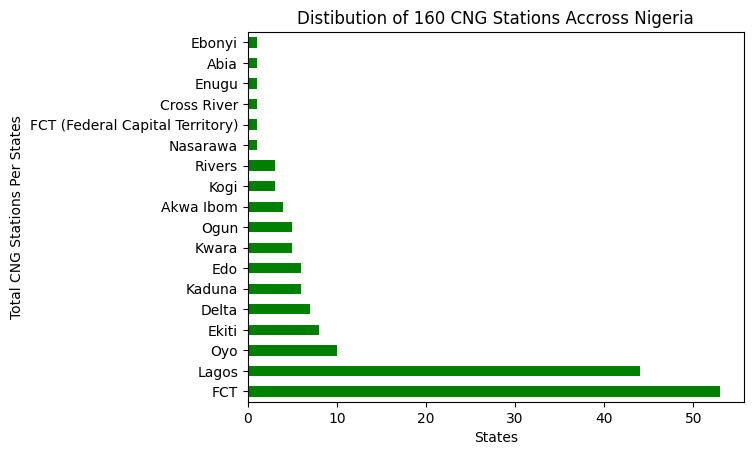

In [132]:
# plot the stations distribution across the states of the federations
df['State'].value_counts().plot(kind='barh', color='green')
plt.xlabel('States')
plt.ylabel('Total CNG Stations Per States')
plt.title('Distibution of 160 CNG Stations Accross Nigeria')

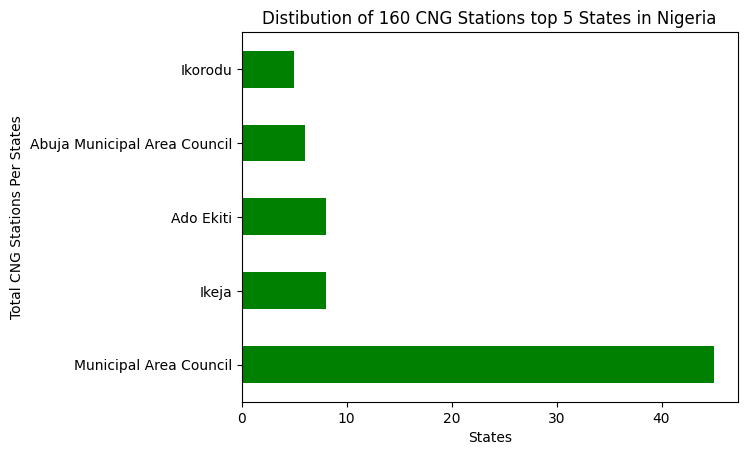

In [133]:
# plot the top5  LGA distribution across the LGA in the federations
top_5 = df['LGA'].value_counts().head()
top_5.plot(kind='barh', color='green')
plt.xlabel('States')
plt.ylabel('Total CNG Stations Per States')
plt.title('Distibution of 160 CNG Stations top 5 States in Nigeria');

In [142]:
# percentage distribution per states
percent_distrib = df['State'].value_counts()/len(df)
print(round(percent_distrib,2)*100)

State
FCT                                33.0
Lagos                              28.0
Oyo                                 6.0
Ekiti                               5.0
Delta                               4.0
Kaduna                              4.0
Edo                                 4.0
Kwara                               3.0
Ogun                                3.0
Akwa Ibom                           2.0
Kogi                                2.0
Rivers                              2.0
Nasarawa                            1.0
FCT (Federal Capital Territory)     1.0
Cross River                         1.0
Enugu                               1.0
Abia                                1.0
Ebonyi                              1.0
Name: count, dtype: float64


### Geocoding


Convert the Address to longitude and latitude

#### Extraction using Geopy Objects for geocoding such as Nominatim and ArcGIS

In [114]:
# lon = []
# lat = []
# for _,col in df.iterrows():
#     geolocator = Nominatim(user_agent="samuel")
#     print(col['Name'])
#     location = geolocator.geocode(col['Name'])
#     print(location.longitude)
#     lon.append(location.longitude)
#     lat.append(location.latitude)

# lon,lat
# # df['longitude','latitude'] = 

#### Extract the lon and lat of the center view of the google map link addeded to the data

In [115]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.3729.169 Safari/537.36",
    "Referer": "https://www.google.com/"
}


In [116]:
# google_lon = []
# google_lat = []

# for _,col in df.iterrows():
#     url = httpx.get(col['google_map_url'],headers=header)
#     page_content = url.content.decode('utf-8').strip()  # Decode bytes to string and strip any extra spaces

#     # Regular expression to extract center coordinates
#     match = re.search(r'center=([\d\.\-]+)%2C([\d\.\-]+)', page_content)

#     if match:
#         latitude = match.group(1)
#         longitude = match.group(2)

#         # append the lon and lat to the empty list
#         google_lon.append(longitude)
#         google_lat.append(latitude)
#     else:
#         print(col['google_map_url'])
#         print("No coordinates found.")


# df['longitude'] = google_lon
# df['latitude'] = google_lat

### Join External Datatst that has the localtions Long and Lat Dataset Generated from Using Google Sheet Google API Service

In [117]:
address_lat_long = pd.read_csv('address_lon_lat.csv', encoding='latin1')
address_lat_long.head()

,Address,latitude,longitude
0,"Plot 487, Asuquo Okon Street, Daki-Biyu, Jabi ...",9.058928,7.429484
1,"KM 42, Lekki-Epe Expressway, Majek Second Gate...",6.468597,3.703737
2,"Plot 16715, Kaduna Abuja Expressway, Kakau Tow...",10.503644,7.433739
3,"49FJ+G6R Kubwa 901101, Federal Capital Territo...",9.123862,7.380516
4,"Basawa Road, Palladan, Zaria, Kaduna Conversio...",11.141346,7.687622


In [118]:
# 'Address' is the common column between df and address_lat_long
df = df.set_index('Address').join(address_lat_long.set_index('Address'), how='left')
df.reset_index(inplace=True)
df.head()

,Address,State,LGA,Name,google_map_url,latitude,longitude
0,"Plot 487, Asuquo Okon Street, Daki-Biyu, Jabi ...",FCT,Abuja Municipal Area Council,Nigeria Institute of Transport Technology (NIT...,https://maps.google.com/?q=Plot+487%2C+Asuquo+...,9.058928,7.429484
1,"KM 42, Lekki-Epe Expressway, Majek Second Gate...",Lagos,Ibeju-Lekki,Femadec Energy Limited Lagos,https://maps.google.com/?q=KM+42%2C+Lekki-Epe+...,6.468597,3.703737
2,"Plot 16715, Kaduna Abuja Expressway, Kakau Tow...",Kaduna,Kaduna North,Rolling Energy Limited Kaduna State,https://maps.google.com/?q=Plot+16715%2C+Kadun...,10.503644,7.433739
3,"49FJ+G6R Kubwa 901101, Federal Capital Territo...",FCT,Abuja Municipal Area Council,ABG Oil and Gas Limited Abuja,https://maps.google.com/?q=49FJ%2BG6R+Kubwa+90...,9.123862,7.380516
4,"Basawa Road, Palladan, Zaria, Kaduna Conversio...",Kaduna,Zaria,Nigerian Institute of Transport Technology (NI...,https://maps.google.com/?q=Basawa+Road%2C+Pall...,11.141346,7.687622


### Convert the Dataframe file to Geopandas and Explore the Map

In [119]:
df.head()

,Address,State,LGA,Name,google_map_url,latitude,longitude
0,"Plot 487, Asuquo Okon Street, Daki-Biyu, Jabi ...",FCT,Abuja Municipal Area Council,Nigeria Institute of Transport Technology (NIT...,https://maps.google.com/?q=Plot+487%2C+Asuquo+...,9.058928,7.429484
1,"KM 42, Lekki-Epe Expressway, Majek Second Gate...",Lagos,Ibeju-Lekki,Femadec Energy Limited Lagos,https://maps.google.com/?q=KM+42%2C+Lekki-Epe+...,6.468597,3.703737
2,"Plot 16715, Kaduna Abuja Expressway, Kakau Tow...",Kaduna,Kaduna North,Rolling Energy Limited Kaduna State,https://maps.google.com/?q=Plot+16715%2C+Kadun...,10.503644,7.433739
3,"49FJ+G6R Kubwa 901101, Federal Capital Territo...",FCT,Abuja Municipal Area Council,ABG Oil and Gas Limited Abuja,https://maps.google.com/?q=49FJ%2BG6R+Kubwa+90...,9.123862,7.380516
4,"Basawa Road, Palladan, Zaria, Kaduna Conversio...",Kaduna,Zaria,Nigerian Institute of Transport Technology (NI...,https://maps.google.com/?q=Basawa+Road%2C+Pall...,11.141346,7.687622


In [120]:
# Creating a GeoDataFrame with point geometry
gdf_point = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude), 
    crs="EPSG:4326"
)

# Displaying the first few rows of the GeoDataFrame
gdf_point.head()

,Address,State,LGA,Name,google_map_url,latitude,longitude,geometry
0,"Plot 487, Asuquo Okon Street, Daki-Biyu, Jabi ...",FCT,Abuja Municipal Area Council,Nigeria Institute of Transport Technology (NIT...,https://maps.google.com/?q=Plot+487%2C+Asuquo+...,9.058928,7.429484,POINT (7.42948 9.05893)
1,"KM 42, Lekki-Epe Expressway, Majek Second Gate...",Lagos,Ibeju-Lekki,Femadec Energy Limited Lagos,https://maps.google.com/?q=KM+42%2C+Lekki-Epe+...,6.468597,3.703737,POINT (3.70374 6.4686)
2,"Plot 16715, Kaduna Abuja Expressway, Kakau Tow...",Kaduna,Kaduna North,Rolling Energy Limited Kaduna State,https://maps.google.com/?q=Plot+16715%2C+Kadun...,10.503644,7.433739,POINT (7.43374 10.50364)
3,"49FJ+G6R Kubwa 901101, Federal Capital Territo...",FCT,Abuja Municipal Area Council,ABG Oil and Gas Limited Abuja,https://maps.google.com/?q=49FJ%2BG6R+Kubwa+90...,9.123862,7.380516,POINT (7.38052 9.12386)
4,"Basawa Road, Palladan, Zaria, Kaduna Conversio...",Kaduna,Zaria,Nigerian Institute of Transport Technology (NI...,https://maps.google.com/?q=Basawa+Road%2C+Pall...,11.141346,7.687622,POINT (7.68762 11.14135)


In [122]:
# explore the points visually
gdf_point.explore()

## 